# Отток клиентов

Из «Бета-Банка» стали уходить клиенты. Каждый месяц. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.

Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. Вам предоставлены исторические данные о поведении клиентов и расторжении договоров с банком. 

Постройте модель с предельно большим значением *F1*-меры. Чтобы сдать проект успешно, нужно довести метрику до 0.59. Проверьте *F1*-меру на тестовой выборке самостоятельно.

Дополнительно измеряйте *AUC-ROC*, сравнивайте её значение с *F1*-мерой.

Источник данных: [https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling](https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling)

Инструкция по выполнению проекта:

Загрузите и подготовьте данные. Поясните порядок действий.

Исследуйте баланс классов, обучите модель без учёта дисбаланса. Кратко опишите выводы.

Улучшите качество модели, учитывая дисбаланс классов. 

Обучите разные модели и найдите лучшую. Кратко опишите выводы.

Проведите финальное тестирование.

## Подготовка данных

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score
import time
from sklearn.utils import shuffle
from sklearn.metrics import roc_auc_score

In [2]:
data = pd.read_csv('/datasets/Churn.csv')

In [3]:
display(data)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,9996,15606229,Obijiaku,771,France,Male,39,5.0,0.00,2,1,0,96270.64,0
9996,9997,15569892,Johnstone,516,France,Male,35,10.0,57369.61,1,1,1,101699.77,0
9997,9998,15584532,Liu,709,France,Female,36,7.0,0.00,1,0,1,42085.58,1
9998,9999,15682355,Sabbatini,772,Germany,Male,42,3.0,75075.31,2,1,0,92888.52,1


Признаки:

**RowNumber** — индекс строки в данных

**CustomerId** — уникальный идентификатор клиента

**Surname** — фамилия

**CreditScore** — кредитный рейтинг

**Geography** — страна проживания

**Gender** — пол

**Age** — возраст

**Tenure** — сколько лет человек является клиентом банка

**Balance** — баланс на счёте

**NumOfProducts** — количество продуктов банка, используемых клиентом

**HasCrCard** — наличие кредитной карты

**IsActiveMember** — активность клиента

**EstimatedSalary** — предполагаемая зарплата

Целевой признак:

**Exited** — факт ухода клиента

Не помню, чтобы прямо в явном виде об этом писалось в течение курса (похоже мысли затрагивались в изучении "дамми-ловушки") , но в данном датафрейме явно нужны не все данные для проведения прогнозирования ухода клиента. В качестве столбцов, которые стоит удалить, так как они явным образом никак не помогут в обучении модели : **RowNumber** - индекс строки, **CustomerId** - уникальный идентификатор клиента, **Surname** - фамилия

In [4]:
del data['RowNumber']
del data['CustomerId']
del data['Surname']

Так же фактически все столбцы имеют названия, не соответсвующие правилам хорошего оформления:

In [5]:
data = data.rename(columns={'CreditScore' : 'credit_score', 'Geography' : 'geography', 'Gender' : 'gender', 
                           'Age' : 'age', 'Tenure' : 'tenure', 'Balance' : 'balance', 'NumOfProducts' : 'num_of_products',
                           'HasCrCard' : 'has_card', 'IsActiveMember' : 'is_active_member', 
                            'EstimatedSalary' : 'estimated_salary', 'Exited' : 'exited'})

In [6]:
display(data)

,credit_score,geography,gender,age,tenure,balance,num_of_products,has_card,is_active_member,estimated_salary,exited
0,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0
...,...,...,...,...,...,...,...,...,...,...,...
9995,771,France,Male,39,5.0,0.00,2,1,0,96270.64,0
9996,516,France,Male,35,10.0,57369.61,1,1,1,101699.77,0
9997,709,France,Female,36,7.0,0.00,1,0,1,42085.58,1
9998,772,Germany,Male,42,3.0,75075.31,2,1,0,92888.52,1


In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 11 columns):
credit_score        10000 non-null int64
geography           10000 non-null object
gender              10000 non-null object
age                 10000 non-null int64
tenure              9091 non-null float64
balance             10000 non-null float64
num_of_products     10000 non-null int64
has_card            10000 non-null int64
is_active_member    10000 non-null int64
estimated_salary    10000 non-null float64
exited              10000 non-null int64
dtypes: float64(3), int64(6), object(2)
memory usage: 859.5+ KB


In [8]:
data.isna().sum()

credit_score          0
geography             0
gender                0
age                   0
tenure              909
balance               0
num_of_products       0
has_card              0
is_active_member      0
estimated_salary      0
exited                0
dtype: int64

Пройдёмся по столбцам, чтобы иметь более точное представление о распредлении данных внутри:

первый столбец - **credit_score** - кредитный рейтинг

In [9]:
data['credit_score'].describe()

count    10000.000000
mean       650.528800
std         96.653299
min        350.000000
25%        584.000000
50%        652.000000
75%        718.000000
max        850.000000
Name: credit_score, dtype: float64

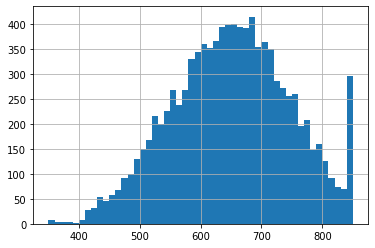

In [10]:
data['credit_score'].hist(bins=50)

Видно, что распределение нормального вида. Сложно сказать насколько данные правдоподобны, ведь неизвестно как начисляется данный кредитный рейтинг, но можно заметить, что у него есть некий "потолок" в виде 850 баллов, где скопилось множетсво дошедших до этого максимума клиентов

Теперь изучим столбец **geography** - страна проживания клиента

In [11]:
data['geography'].value_counts()

France     5014
Germany    2509
Spain      2477
Name: geography, dtype: int64

Как видно, работать будем всего с 3-мя странами, которые встречаются примерно одинаково. Перевести эти категориальные значения в численные можно будет при помощи прямого кодирования

**gender** - пол клиента

In [12]:
data['gender'].value_counts()

Male      5457
Female    4543
Name: gender, dtype: int64

Тут точно так же признаки выглядят примерно равными по распределению и будут переведены в численные при помощи прямого кодирования

**age** - возраст клиента

In [13]:
data['age'].describe()

count    10000.000000
mean        38.921800
std         10.487806
min         18.000000
25%         32.000000
50%         37.000000
75%         44.000000
max         92.000000
Name: age, dtype: float64

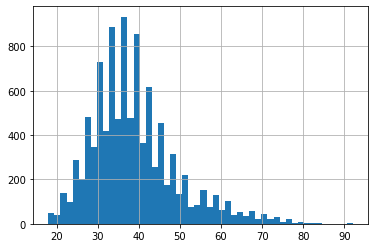

In [14]:
data['age'].hist(bins=50)

Распределение по возрасту выглядит вполне правдоподобным

**tenure** - сколько клиент является клиентом банка

В данном столбце есть множество пустых строк с *0* в годах сторудничества с банком. Возможно, это клиенты, которые являются клиентами банка меньше 1 года?

In [15]:
data['tenure'].value_counts()

1.0     952
2.0     950
8.0     933
3.0     928
5.0     927
7.0     925
4.0     885
9.0     882
6.0     881
10.0    446
0.0     382
Name: tenure, dtype: int64

In [16]:
data['tenure'].isna().sum()

909

In [17]:
display(data[data['tenure'].isna() == True])

,credit_score,geography,gender,age,tenure,balance,num_of_products,has_card,is_active_member,estimated_salary,exited
30,591,Spain,Female,39,NaN,0.00,3,1,0,140469.38,1
48,550,Germany,Male,38,NaN,103391.38,1,0,1,90878.13,0
51,585,Germany,Male,36,NaN,146050.97,2,0,0,86424.57,0
53,655,Germany,Male,41,NaN,125561.97,1,0,0,164040.94,1
60,742,Germany,Male,35,NaN,136857.00,1,0,0,84509.57,0
...,...,...,...,...,...,...,...,...,...,...,...
9944,744,Germany,Male,41,NaN,190409.34,2,1,1,138361.48,0
9956,520,France,Female,46,NaN,85216.61,1,1,0,117369.52,1
9964,479,France,Male,34,NaN,117593.48,2,0,0,113308.29,0
9985,659,France,Male,36,NaN,123841.49,2,1,0,96833.00,0


In [18]:
data.corr()

,credit_score,age,tenure,balance,num_of_products,has_card,is_active_member,estimated_salary,exited
credit_score,1.000000,-0.003965,-0.000062,0.006268,0.012238,-0.005458,0.025651,-0.001384,-0.027094
age,-0.003965,1.000000,-0.013134,0.028308,-0.030680,-0.011721,0.085472,-0.007201,0.285323
tenure,-0.000062,-0.013134,1.000000,-0.007911,0.011979,0.027232,-0.032178,0.010520,-0.016761
balance,0.006268,0.028308,-0.007911,1.000000,-0.304180,-0.014858,-0.010084,0.012797,0.118533
num_of_products,0.012238,-0.030680,0.011979,-0.304180,1.000000,0.003183,0.009612,0.014204,-0.047820
has_card,-0.005458,-0.011721,0.027232,-0.014858,0.003183,1.000000,-0.011866,-0.009933,-0.007138
is_active_member,0.025651,0.085472,-0.032178,-0.010084,0.009612,-0.011866,1.000000,-0.011421,-0.156128
estimated_salary,-0.001384,-0.007201,0.010520,0.012797,0.014204,-0.009933,-0.011421,1.000000,0.012097
exited,-0.027094,0.285323,-0.016761,0.118533,-0.047820,-0.007138,-0.156128,0.012097,1.000000


Явной корреляции у данного столбца нету с какими-то другими, чтобы заполнить при их помощи, да и по срезу данных с пропущенными значениями в столбце **tenure** тоже не скажешь, что это точно новые клиенты - значения в остальных столбцах вроде кредитного рейтинга **credit_score** или например числа товаров **num_of_products** у них далеко не нулевые. Так что поскольку явной подсказки как заполнить эти пропущенные строки нет - предлагаю обучить модель без них и отбросить

In [19]:
data = data.dropna()

Переведём значения из float в integer

In [20]:
data['tenure'] = data['tenure'].astype('int')

**balance** - баланс на счёте

In [21]:
data['balance'].describe()

count      9091.000000
mean      76522.740015
std       62329.528576
min           0.000000
25%           0.000000
50%       97318.250000
75%      127561.890000
max      250898.090000
Name: balance, dtype: float64

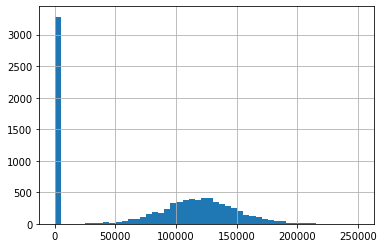

In [22]:
data['balance'].hist(bins=50)

есть весьма большое число клиентов с 0 балансом на счёте

**num_of_products** - число используемых продуктов

In [23]:
data['num_of_products'].value_counts()

1    4617
2    4184
3     234
4      56
Name: num_of_products, dtype: int64

тут тоже можем сказать, что подавляющая часть клиентов использует 1-2 продукта, и крайне малое число клиентов 3-4

**has_card** - есть ли у клиента карта

In [24]:
data['has_card'].value_counts()

1    6409
0    2682
Name: has_card, dtype: int64

Клиеинтов с картой подавляющее, но не многократно превышающее большинство

**is_active_member** - активность клиента

In [25]:
data['is_active_member'].value_counts()

1    4687
0    4404
Name: is_active_member, dtype: int64

Активных и неактивных клиентов примерно поровну

**estimated_salary** - предполгаемая зарплата

In [26]:
data['estimated_salary'].describe()

count      9091.000000
mean     100181.214924
std       57624.755647
min          11.580000
25%       51227.745000
50%      100240.200000
75%      149567.210000
max      199992.480000
Name: estimated_salary, dtype: float64

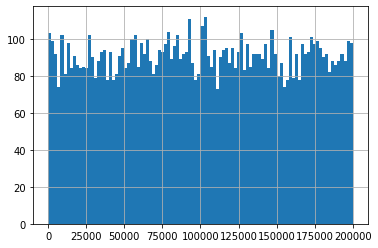

In [27]:
data['estimated_salary'].hist(bins=100)

Уровни зарплат заметно отличаются, но при этом клиенты распределены фактически поровну

**exited** - факт ухода клиента

In [28]:
data['exited'].value_counts()

0    7237
1    1854
Name: exited, dtype: int64

большинство клиентов не уходили от банка: из общего датафрейма можно сказать, что продолжили быть клиентами банка примерно 80 %

В датафрейме есть 2 категориальных признака: **geography** и **gender** - их стоит перевести при помощи прямого кодирования в численные значения, для того чтобы по ним можно было учить модель

In [29]:
data_ohe = pd.get_dummies(data, drop_first=True)

In [30]:
display(data_ohe)

,credit_score,age,tenure,balance,num_of_products,has_card,is_active_member,estimated_salary,exited,geography_Germany,geography_Spain,gender_Male
0,619,42,2,0.00,1,1,1,101348.88,1,0,0,0
1,608,41,1,83807.86,1,0,1,112542.58,0,0,1,0
2,502,42,8,159660.80,3,1,0,113931.57,1,0,0,0
3,699,39,1,0.00,2,0,0,93826.63,0,0,0,0
4,850,43,2,125510.82,1,1,1,79084.10,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...
9994,800,29,2,0.00,2,0,0,167773.55,0,0,0,0
9995,771,39,5,0.00,2,1,0,96270.64,0,0,0,1
9996,516,35,10,57369.61,1,1,1,101699.77,0,0,0,1
9997,709,36,7,0.00,1,0,1,42085.58,1,0,0,0


Так как у признаков весьма разный масштаб (у столбцов кредитного рейтинга, числа лет сотрудничества, возраста, баланса на счету, числа продуктов банка у клиента и предполагаемой зарплаты) - потребуется масштабирование признаков. Так же можно сказать, что клиентов ушло из банка намного меньше, чем осталось, то есть для более точной работы будет необходимо применить балансирование

In [31]:
numeric = ['credit_score', 'age', 'tenure', 'balance', 'num_of_products' ,'estimated_salary']

Перед дальнейшим обучением моделей сначала поделим данные на тренировочную, валидационную и тестовую выборки

In [32]:
train, validate, test = np.split(data_ohe.sample(frac=1, random_state=42), [int(0.6*len(data)), int(0.8*len(data))])

In [33]:
display(train)

,credit_score,age,tenure,balance,num_of_products,has_card,is_active_member,estimated_salary,exited,geography_Germany,geography_Spain,gender_Male
3639,680,48,8,115115.38,1,1,0,139558.60,1,1,0,0
2835,653,35,6,116662.96,2,1,1,23864.21,0,0,1,1
3378,529,72,5,94216.05,1,1,1,78695.68,0,1,0,1
1477,776,37,2,0.00,1,0,1,8065.00,0,0,0,1
4919,682,50,10,128039.01,1,1,1,102260.16,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...
6350,640,48,1,111599.32,1,0,1,135995.58,0,1,0,1
6595,601,24,7,0.00,2,0,0,144660.42,0,0,1,1
1677,784,40,8,0.00,2,1,0,108891.30,0,0,1,0
4238,655,39,6,94631.26,2,1,1,148948.52,0,0,0,0


In [34]:
display(validate)

,credit_score,age,tenure,balance,num_of_products,has_card,is_active_member,estimated_salary,exited,geography_Germany,geography_Spain,gender_Male
7191,501,42,9,114631.23,1,0,1,91429.74,0,0,0,1
3547,662,35,6,0.00,2,0,0,2423.90,1,0,1,0
4019,620,31,2,166833.86,2,1,1,135171.60,0,0,1,1
7525,580,35,9,121355.19,1,0,1,35671.45,0,1,0,1
7763,614,36,1,44054.84,1,1,1,73329.08,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...
711,634,35,6,116269.01,1,1,0,129964.94,0,1,0,1
6698,725,31,6,0.00,1,0,0,61326.43,0,0,0,0
348,654,32,1,114510.85,1,1,1,126143.23,0,1,0,0
9275,427,42,1,75681.52,1,1,1,57098.00,0,1,0,1


In [35]:
display(test)

,credit_score,age,tenure,balance,num_of_products,has_card,is_active_member,estimated_salary,exited,geography_Germany,geography_Spain,gender_Male
5977,704,40,6,95452.89,1,0,1,179964.55,0,0,0,0
476,605,31,1,117992.59,1,1,1,183598.77,0,1,0,0
8172,759,31,8,0.00,2,1,1,99086.74,0,0,1,1
115,628,30,9,132351.29,2,1,1,74169.13,0,1,0,0
3352,591,40,2,99886.42,2,1,1,88695.19,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
6312,658,28,9,152812.58,1,1,0,166682.57,0,1,0,0
5722,681,34,3,0.00,2,0,0,55816.20,0,0,0,1
5940,849,41,6,0.00,2,1,1,169203.51,1,0,0,0
966,563,34,6,139810.34,1,1,1,152417.79,0,0,0,0


In [36]:
features_train = train.drop(['exited'], axis=1)
target_train = train['exited']
features_validate = validate.drop(['exited'], axis=1)
target_validate = validate['exited']
features_test = test.drop(['exited'], axis=1)
target_test = test['exited']

Теперь применим масштабирование к столбцам признаков, которые в этом нуждаются:

In [37]:
scaler = StandardScaler()
scaler.fit(features_train[numeric]);

In [38]:
features_train[numeric] = scaler.transform(features_train[numeric])
features_validate[numeric] = scaler.transform(features_validate[numeric])
features_test[numeric] = scaler.transform(features_test[numeric]);

Теперь призанки отмасштабированы. Обучим далее несколько моделей без применения балансирования, а затем с применением

## Борьба с дисбалансом

Для начала обучим модель **решающего дерева**

У решающего дерева есть 3 гиперпараметра, которые были рассмотрены: глубина дерева, которая не должна быть слишком большой для избежания переобучения, но и не слишком малой для недообучения; min_samples_split - минимальное кол-во выборок для разделения внутреннего узла; min_samples_leaf - минимальное кол-во образцов в листовом узле

Напишем цикл, который прогонит каждый из этих параметров в определённом диапазоне и найдём их наилучшую комбинацию с наибольшим значением f1-меры. Так как решающее дерево самая быстрообучаемая модель, вроде бы не особо нагружающая систему, позволим себе сделать диапазоны достаточно большими:

In [39]:
best_tree_f_score = 0
best_tree_depth = None
best_samples_split = None
best_samples_leaf = None
best_auc_roc = None

start_time = time.perf_counter()

for depth in range(2,30):
    for split in range(2,30):
        for leaf in range(1,30):
            model = DecisionTreeClassifier(random_state=12345, max_depth=depth, min_samples_split=split, min_samples_leaf=leaf)
            model.fit(features_train, target_train)
            predicted_validate = model.predict(features_validate)
            f_score = f1_score(target_validate, predicted_validate)
            probabilities_validate = model.predict_proba(features_validate)
            probabilities_one_validate = probabilities_validate[:, 1]
            auc_roc = roc_auc_score(target_validate, probabilities_one_validate)
            if f_score > best_tree_f_score:
                best_tree_f_score = f_score
                best_tree_depth = depth
                best_samples_split = split
                best_samples_leaf = leaf
                best_auc_roc = auc_roc

finish_time = time.perf_counter()                

tree_study_time = finish_time - start_time

print(f'Лучшая точность наблюдается при глубине:{best_tree_depth}')
print(f'Лучшая точность наблюдается при минимальном кол-ве выборок для разделения: {best_samples_split}')
print(f'Лушчая точность наблюдается при минимальном кол-ве образцов в одном листе: {best_samples_leaf}')
print(f'Лучшая f1 мера решающего дерева: {best_tree_f_score}')
print(f'Значение величины AUC-ROC: {best_auc_roc}')
print()
print(f'Затраченное время на обучения наилучшего решаюшего дерева: {tree_study_time} секунд')

Лучшая точность наблюдается при глубине:7
Лучшая точность наблюдается при минимальном кол-ве выборок для разделения: 20
Лушчая точность наблюдается при минимальном кол-ве образцов в одном листе: 1
Лучшая f1 мера решающего дерева: 0.5638474295190712
Значение величины AUC-ROC: 0.8338897604652943

Затраченное время на обучения наилучшего решаюшего дерева: 618.5404800050019 секунд


Сделаем аналогичные вычисления, только уже сбалансировав классы, добавив редким классам больший вес

In [40]:
best_tree_f_score = 0
best_tree_depth = None
best_samples_split = None
best_samples_leaf = None
best_auc_roc = None

start_time = time.perf_counter()

for depth in range(2,30):
    for split in range(2,30):
        for leaf in range(1,30):
            model = DecisionTreeClassifier(random_state=12345, max_depth=depth, min_samples_split=split, 
                                           min_samples_leaf=leaf, class_weight='balanced')
            model.fit(features_train, target_train)
            predicted_validate = model.predict(features_validate)
            f_score = f1_score(target_validate, predicted_validate)
            probabilities_validate = model.predict_proba(features_validate)
            probabilities_one_validate = probabilities_validate[:, 1]
            auc_roc = roc_auc_score(target_validate, probabilities_one_validate)
            if f_score > best_tree_f_score:
                best_tree_f_score = f_score
                best_tree_depth = depth
                best_samples_split = split
                best_samples_leaf = leaf
                best_auc_roc = auc_roc

finish_time = time.perf_counter()                

tree_study_time = finish_time - start_time

print(f'Лучшая точность наблюдается при глубине:{best_tree_depth}')
print(f'Лучшая точность наблюдается при минимальном кол-ве выборок для разделения: {best_samples_split}')
print(f'Лушчая точность наблюдается при минимальном кол-ве образцов в одном листе: {best_samples_leaf}')
print(f'Лучшая f1 мера решающего дерева: {best_tree_f_score}')
print(f'Значение величины AUC-ROC: {best_auc_roc}')
print()
print(f'Затраченное время на обучения наилучшего решаюшего дерева: {tree_study_time} секунд')

Лучшая точность наблюдается при глубине:9
Лучшая точность наблюдается при минимальном кол-ве выборок для разделения: 28
Лушчая точность наблюдается при минимальном кол-ве образцов в одном листе: 6
Лучшая f1 мера решающего дерева: 0.574279379157428
Значение величины AUC-ROC: 0.8282342924925383

Затраченное время на обучения наилучшего решаюшего дерева: 665.1459047249955 секунд


Можем заметить, что f1 мера и значение AUC-ROC фактически не изменились, но зато при введении балансирования классов поменялись оптимальные гиперпараметры

Теперь рассмотрим модель **случайного леса**

In [41]:
best_forest_f_score = 0
best_tree_number = None
best_tree_depth = None
best_samples_split = None
best_auc_roc = None

start_time = time.perf_counter()

for tree in range(2,20):
    for max_depth in range(2,20):
        for split in range(2,20):
            model = RandomForestClassifier(random_state=12345, n_estimators=tree, max_depth=max_depth, min_samples_split=split)
            model.fit(features_train, target_train)
            predicted_validate = model.predict(features_validate)
            f_score = f1_score(target_validate, predicted_validate)
            probabilities_validate = model.predict_proba(features_validate)
            probabilities_one_validate = probabilities_validate[:, 1]
            auc_roc = roc_auc_score(target_validate, probabilities_one_validate)
            if f_score > best_forest_f_score:
                best_forest_f_score = f_score
                best_tree_number = tree
                best_tree_depth = max_depth
                best_samples_split = split
                best_auc_roc = auc_roc

finish_time = time.perf_counter()                

forest_study_time = finish_time - start_time

print(f'Лучшая точность наблюдается при глубине:{best_tree_depth}')
print(f'Лучшая точность наблюдается при числе деревьев: {best_tree_number}')
print(f'Лучшая точность наблюдается при минимальном кол-ве выборок для разделения: {best_samples_split}')
print(f'Лучшая f1 мера случайного леса: {best_forest_f_score}')
print(f'Значение величины AUC-ROC: {best_auc_roc}')
print()
print(f'Затраченное время на обучения случайного леса: {forest_study_time} секунд')

Лучшая точность наблюдается при глубине:16
Лучшая точность наблюдается при числе деревьев: 13
Лучшая точность наблюдается при минимальном кол-ве выборок для разделения: 7
Лучшая f1 мера случайного леса: 0.6102819237147595
Значение величины AUC-ROC: 0.834308754878702

Затраченное время на обучения случайного леса: 469.0786829999997 секунд


Теперь попробуем обучить модель случайного леса с учётом балансировки:

In [42]:
best_forest_f_score = 0
best_tree_number = None
best_tree_depth = None
best_samples_split = None
best_auc_roc = None

start_time = time.perf_counter()

for tree in range(1,20):
    for max_depth in range(1,20):
        for split in range(2,20):
            model = RandomForestClassifier(random_state=12345, n_estimators=tree, max_depth=max_depth, class_weight='balanced',
                                          min_samples_split=split)
            model.fit(features_train, target_train)
            predicted_validate = model.predict(features_validate)
            f_score = f1_score(target_validate, predicted_validate)
            probabilities_validate = model.predict_proba(features_validate)
            probabilities_one_validate = probabilities_validate[:, 1]
            auc_roc = roc_auc_score(target_validate, probabilities_one_validate)
            if f_score > best_forest_f_score:
                best_forest_f_score = f_score
                best_tree_number = tree
                best_tree_depth = max_depth
                best_samples_split = split
                best_auc_roc = auc_roc

finish_time = time.perf_counter()                

forest_study_time = finish_time - start_time

print(f'Лучшая точность наблюдается при глубине:{best_tree_depth}')
print(f'Лучшая точность наблюдается при числе деревьев: {best_tree_number}')
print(f'Лучшая точность наблюдается при минимальном кол-ве выборок для разделения: {best_samples_split}')
print(f'Лучшая f1 мера случайного леса: {best_forest_f_score}')
print(f'Значение величины AUC-ROC: {best_auc_roc}')
print()
print(f'Затраченное время на обучения случайного леса: {forest_study_time} секунд')

Лучшая точность наблюдается при глубине:18
Лучшая точность наблюдается при числе деревьев: 7
Лучшая точность наблюдается при минимальном кол-ве выборок для разделения: 13
Лучшая f1 мера случайного леса: 0.631578947368421
Значение величины AUC-ROC: 0.8407017678120456

Затраченное время на обучения случайного леса: 485.8686471800029 секунд


Как и для решающего дерева - для случайного леса момент с несбалансированными данными оказался несильно влияющим на итоговую f1 меру, если его учитывать. При тех же гиперпараметрах учёт редковстречающихся классов вероятно более заметен, но если говорить о переборе в цикле при поиске наиболее оптимальной модели - итоговый лучший результат будет уже действительно с другим оптимальным набором гиперпараметров,но f1 мера сама по себе увеличится крайне незначительно относительно прошлого лучшего результата

Теперь рассмотрим модель **логистической регрессии**

In [43]:
start_time = time.perf_counter()

model = LogisticRegression(random_state=12345, solver='liblinear')
model.fit(features_train, target_train)
predicted_validate = model.predict(features_validate)
f_score = f1_score(target_validate, predicted_validate)
probabilities_validate = model.predict_proba(features_validate)
probabilities_one_validate = probabilities_validate[:, 1]
auc_roc = roc_auc_score(target_validate, probabilities_one_validate)

finish_time = time.perf_counter()

logreg_study_time = finish_time - start_time

print(f'f1 мера логистической регрессии: {f_score}')
print(f'Значение величины AUC-ROC: {auc_roc}')
print()
print(f'Затраченное время на обучения модели логистической регрессии: {logreg_study_time} секунд')

f1 мера логистической регрессии: 0.3404255319148936
Значение величины AUC-ROC: 0.7551714241983624

Затраченное время на обучения модели логистической регрессии: 0.03745524599798955 секунд


Модель логистической регрессии с учётом балансировки:

In [44]:
start_time = time.perf_counter()

model = LogisticRegression(random_state=12345, solver='liblinear', class_weight='balanced')
model.fit(features_train, target_train)
predicted_validate = model.predict(features_validate)
f_score = f1_score(target_validate, predicted_validate)
probabilities_validate = model.predict_proba(features_validate)
probabilities_one_validate = probabilities_validate[:, 1]
auc_roc = roc_auc_score(target_validate, probabilities_one_validate)

finish_time = time.perf_counter()

logreg_study_time = finish_time - start_time

print(f'f1 мера логистической регрессии: {f_score}')
print(f'Значение величины AUC-ROC: {auc_roc}')
print()
print(f'Затраченное время на обучения модели логистической регрессии: {logreg_study_time} секунд')

f1 мера логистической регрессии: 0.48000000000000004
Значение величины AUC-ROC: 0.7557626080967321

Затраченное время на обучения модели логистической регрессии: 0.028277900004468393 секунд


Для логистической регресси, как видно, момент с увеличением веса редко встречающихся классов крайне важен: f1 мера фактически взлетела в полтора раза

Общий итог по работе со всеми моделями: учёт того, что есть редковстречающиеся классы не особо сильно даёт выигрыш по f1 мере для решающего дерева и случайного леса, но вот для логистической регрессии это крайне важный момент, который позволил поднять f1 меру фактически в полтора раза. Метрика AUC-ROC является фактически пропорциональной для F1 - у моделей с высоким значением f1 точно так же наблюдаются высокие значения AUC-ROC , но оно и логично - оба этих параметра чем ближе к 1, тем совершеннее модель, и рост одного должен логичным образом коррелировать с ростом другого

Лучший результат по итогу показал случайный лес - там f1 меру удалось поднять фактически до 0.6, но был использован лишь 1 способ борьбы с дисбалансом - прописывание гиперпараметра class_weight="balanced". Существует так же способ искусственного уменьшения/увеличения выборки (выберем вариант с уменьшением), при котором случайным образом отрбасывается часть преобладающих объектов, чтобы "уравнять" классы 0 и 1 (в данном случае 0 - число оставшихся клиентов, сильно выше числа ушедших 1). Заново возьмём модель случайного леса и используем ещё один способ борьбы с дисбаласом - пусть значение fraction, которое будем отбрасывать, равно 20 %. 

In [45]:
fraction = 0.2

In [46]:
# разделим обучающую выборку на положительные и отрицательные объекты
features_zeros = features_train[target_train == 0]
features_ones = features_train[target_train == 1]
target_zeros = target_train[target_train == 0]
target_ones = target_train[target_train == 1]

In [47]:
features_downsampled = shuffle(pd.concat(
        [features_zeros.sample(frac=fraction, random_state=12345)] + [features_ones]))
target_downsampled = shuffle(pd.concat(
    [target_zeros.sample(frac=fraction, random_state=12345)] + [target_ones]))

In [48]:
best_forest_f_score = 0
best_tree_number = None
best_tree_depth = None
best_samples_split = None
best_auc_roc = None

start_time = time.perf_counter()

for tree in range(2,20):
    for max_depth in range(2,20):
        for split in range(2,20):
            model = RandomForestClassifier(random_state=12345, n_estimators=tree, max_depth=max_depth, min_samples_split=split)
            model.fit(features_downsampled, target_downsampled)
            predicted_validate = model.predict(features_validate)
            f_score = f1_score(target_validate, predicted_validate)
            probabilities_validate = model.predict_proba(features_validate)
            probabilities_one_validate = probabilities_validate[:, 1]
            auc_roc = roc_auc_score(target_validate, probabilities_one_validate)
            best_auc_roc = auc_roc
            if f_score > best_forest_f_score:
                best_forest_f_score = f_score
                best_tree_number = tree
                best_tree_depth = max_depth
                best_samples_split = split

finish_time = time.perf_counter()                

forest_study_time = finish_time - start_time

print(f'Лучшая точность наблюдается при глубине:{best_tree_depth}')
print(f'Лучшая точность наблюдается при числе деревьев: {best_tree_number}')
print(f'Лучшая точность наблюдается при минимальном кол-ве выборок для разделения: {best_samples_split}')
print(f'Лучшая f1 мера случайного леса: {best_forest_f_score}')
print(f'Значение величины AUC-ROC: {best_auc_roc}')
print()
print(f'Затраченное время на обучения случайного леса: {forest_study_time} секунд')

Лучшая точность наблюдается при глубине:3
Лучшая точность наблюдается при числе деревьев: 19
Лучшая точность наблюдается при минимальном кол-ве выборок для разделения: 7
Лучшая f1 мера случайного леса: 0.33023255813953495

Затраченное время на обучения случайного леса: 251.15208784000424 секунд


Как видно, этот способ не очень хорошо сработал - значение f1 даже значительно упало по сравнению с обученным случайным лесом без искусственного отбрасывания слишком часто встречающихся значений. Примем за лучшую модель случайный лес с гиперпараметром class_weight='balanced' и остальными оптимальными гиперпараметрами, так как он показал наилучший результат на валидационных данных. Именно по нему и будем смотреть f1 меру на тестовой выборке.

## Тестирование модели

In [49]:
model = RandomForestClassifier(random_state=12345, n_estimators=7, max_depth=18, 
                               class_weight='balanced', min_samples_split=13)
model.fit(features_train, target_train)
predicted_test = model.predict(features_test)
f_score = f1_score(target_test, predicted_test)
print(f'f1 мера на тестовых данных: {f_score}')

f1 мера на тестовых данных: 0.5901201602136181


Требуемая f1 мера в 0.59 достигнута!

Посчитаем значение AUC-ROC (равняется 0.5 для случайной модели и 1 для идеальной)

In [50]:
probabilities_test = model.predict_proba(features_test)
probabilities_one_test = probabilities_test[:, 1]
auc_roc = roc_auc_score(target_test, probabilities_one_test)
print(auc_roc)

0.8197830755286781


Как видно, данный параметр вышел вполне добротным - получившаяся модель конечно не идеальна, и несколько делека от значения AUC-ROC = 1 , но заментно лучше, чем просто случайная модель со своими 0.5 , так что можно считать итоговую обученную модель вполне годной.

**Итог**: проведена предобработка данных, их масштабирование, устранены данные с пропусками, выполнено разделение данных на тренировочную, тестовую и валидационную выборки. По тестовой и валидационной выборке получена наилучшая модель, проанализировано как на неё влияют способы борьбы с дисбалансом. Установлено, что выбранная модель показывает требуемый высокий уровень f1 меры и значение AUC_ROC